### Compare CONUS2 and SNOTEL SWE ###
DTT, 06/23
### Need to update the documentation for SWE (copied Streamflow notebook)

This notebook reads in CSVs of CONUS2 daily mean flow [cms] and daily mean USGS flow [cms] and creates comparison hydrographs. Gages have been matched between the two csv's to make sure that we're comparing viable gage locations in `1_Organize_Streamflow.ipynb`. 

Inputs:
- CONUS2 daily mean flow csv in [cms], ouput from `1_Organize_Streamflow.ipynb`
- USGS daily mean flow csv in [cms], ouput from `1_Organize_Streamflow.ipynb` 
- USGS gage metadata csv, ouput from `1_Organize_Streamflow.ipynb` 

Outputs:
- Hydrographs of USGS and CONUS2 flow

Notes:

In [2]:
import sys
from parflow.tools.io import read_pfb,write_pfb
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
#import geopandas as gpd

In [21]:
water_year = 2003
# Directory containing output csv's from `Make_CONUS2_streamflow_csv.py`
#organized_dir = '/glade/work/tijerina/PFCONUS2-analysis/scripts/Validation/Streamflow/Organized_Daily_Flow'
organized_dir = '/home/dtt2/CONUS2/PFCONUS2-analysis/scripts/Validation/SNOTEL/SWE/Organized_Daily_SWE'


# Where you want to save plots, etc. to
#plot_dir = '/glade/work/tijerina/PFCONUS2-analysis/scripts/Validation/Streamflow/Figures'
plot_dir = '/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/spinup_Validation/SNOTEL/SWE'
print(f'Figures saving to: {plot_dir}')


# names of csv files
pf_csv = 'PFCONUS2_Daily_matched_SWE_mm_2003.csv'
obs_csv = 'SNOTEL_Daily_matched_SWE_mm_2003.csv'
metadata_csv = 'SNOTEL_metadata_matched_SWE_mm_2003.csv'
stats_csv = 'Summary_SNOTEL_CONUS2_WY2003.csv'

Figures saving to: /hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/spinup_Validation/SNOTEL/SWE


### Read in files
Read in PF flow, USGS flow, USGS metadata, and calculated stats from `SaveStreamflowStats.ipynb`

In [8]:
### read in CONUS2 daily flow matched csv
pfdata = pd.read_csv(f'{organized_dir}/{pf_csv}',index_col=['site_id'])
#pf_flow_matched = pfdata.drop(columns=['USGS_lat', 'USGS_lon', 'x_new_adj', 'y_new_adj'])
pfdata.head()

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-21,2003-09-22,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
1000:OR:SNTL,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005:CO:SNTL,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1006:NV:SNTL,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1008:MT:SNTL,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1009:MT:SNTL,0.0,0.0,0.0,0.925932,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
### read in USGS daily flow matched csv
usgsdata = pd.read_csv(f'{organized_dir}/{obs_csv}',index_col=['site_id']) 
usgsdata.head()
# # change zero values in USGS df so that we can calculate stats without errors
# usgsdata = usgsdata.where(usgsdata>0, 0.0001)

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-21,2003-09-22,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
1000:OR:SNTL,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005:CO:SNTL,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1006:NV:SNTL,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1008:MT:SNTL,0.0,0.0,0.0,0.0,2.54,7.62,2.54,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1009:MT:SNTL,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
### read in USGS streamflow gage metadata for all gages with flow in October
usgs_gage_metadata = pd.read_csv(f'{organized_dir}/{metadata_csv}',index_col=['site_id'])#, 
#usgs_gage_metadata = usgs_gage_metadata.drop(columns=['Unnamed: 0'])
#usgs_all_gages = usgs_all_gages.transpose() #transpose df for easier plotting
usgs_gage_metadata

,site_type,agency,site_name,site_id_agency,site_query_url,date_metadata_last_updated,latitude,longitude,state,huc,...,file_path,county_name,elevation,shef_id,acton_id,conus1_x,conus1_y,conus2_x,conus2_y,num_obs
site_id,,,,,,,,,,,,,,,,,,,,,
1000:OR:SNTL,SNOTEL station,NRCS,Annie Springs,1000:OR:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,42.87007,-122.16518,OR,180102030101,...,/hydrodata/national_obs/swe/data/daily/1000:OR...,Klamath,6010.0,ANSO3,22G06S,NaN,NaN,258,2286,365
1005:CO:SNTL,SNOTEL station,NRCS,Ute Creek,1005:CO:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,37.61480,-105.37322,CO,130100020604,...,/hydrodata/national_obs/swe/data/daily/1005:CO...,Costilla,10734.0,UTCC2,05M17S,1063.0,495.0,1490,1448,365
1006:NV:SNTL,SNOTEL station,NRCS,Lewis Peak,1006:NV:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,40.35720,-116.86470,NV,160401070903,...,/hydrodata/national_obs/swe/data/daily/1006:NV...,Lander,7370.0,LWPN2,16J01S,137.0,957.0,592,1908,365
1008:MT:SNTL,SNOTEL station,NRCS,Onion Park,1008:MT:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.91348,-110.85360,MT,100301030801,...,/hydrodata/national_obs/swe/data/daily/1008:MT...,Meagher,7410.0,ONPM8,10C22S,753.0,1575.0,1196,2499,365
1009:MT:SNTL,SNOTEL station,NRCS,Stringer Creek,1009:MT:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.92690,-110.90198,MT,100301030801,...,/hydrodata/national_obs/swe/data/daily/1009:MT...,Meagher,6550.0,STCM8,10C23S,750.0,1577.0,1193,2501,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984:WA:SNTL,SNOTEL station,NRCS,Spruce Springs,984:WA:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.18287,-117.54155,WA,170601030201,...,/hydrodata/national_obs/swe/data/daily/984:WA:...,Garfield,5700.0,SPGW1,17C04S,233.0,1598.0,697,2528,365
985:WA:SNTL,SNOTEL station,NRCS,Sourdough Gulch,985:WA:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.23718,-117.39438,WA,170601030202,...,/hydrodata/national_obs/swe/data/daily/985:WA:...,Asotin,4000.0,SGUW1,17C06S,245.0,1601.0,709,2531,365
988:ID:SNTL,SNOTEL station,NRCS,Hidden Lake,988:ID:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,48.89370,-116.75748,ID,170101040502,...,/hydrodata/national_obs/swe/data/daily/988:ID:...,Boundary,5040.0,HDLI1,16A12S,361.0,1879.0,825,2796,365


In [6]:
usgs_gage_metadata.columns

Index(['site_type', 'agency', 'site_name', 'site_id_agency', 'site_query_url',
       'date_metadata_last_updated', 'latitude', 'longitude', 'state', 'huc',
       'tz_cd', 'doi', 'observation_id', 'site_id:1', 'var_id',
       'start_date_listed', 'end_date_listed', 'is_current', 'is_series',
       'first_date_data_available', 'last_date_data_available', 'record_count',
       'date_verified_through', 'latest_download_date', 'file_path',
       'conus1_x', 'conus1_y', 'conus1_latitude', 'conus1_longitude',
       'conus1_moved', 'conus1_parflow_drainage_area', 'conus2_x', 'conus2_y',
       'conus2_latitude', 'conus2_longitude', 'conus2_moved',
       'conus2_parflow_drainage_area', 'gages_drainage_sqkm', 'bound_source',
       'class', 'aggecoregion', 'hydro_disturb_indx', 'wr_report_remarks',
       'adr_citation', 'screening_comments', 'basin_compactness',
       'basin_elevation_mean_meters', 'basin_elevation_max_meters',
       'basin_elevation_min_meters', 'basin_elevation_medi

In [22]:
### read in USGS daily flow matched csv
stats_df = pd.read_csv(f'{organized_dir}/{stats_csv}',index_col=['site_id']) 
stats_df

,latitude,longitude,conus2_x,conus2_y,huc,HUC2,USGS_mean_mm,PF_mean_mm,pf_minus_obs,absrelbias,bias,pbias,srho,r2,rmse,mse
site_id,,,,,,,,,,,,,,,,
1000:OR:SNTL,42.87007,-122.16518,258,2286,180102030101,180102,407.172478,261.951316,-53005.723969,0.356658,-0.356658,-35.665761,0.984528,0.766965,207.868536,43209.328082
1005:CO:SNTL,37.61480,-105.37322,1490,1448,130100020604,130100,116.130234,57.069518,-21557.161585,0.508573,-0.508573,-50.857313,0.987093,0.607546,84.807882,7192.376818
1006:NV:SNTL,40.35720,-116.86470,592,1908,160401070903,160401,23.082743,0.875038,-8105.812470,0.962091,-0.962091,-96.209125,0.484683,-0.434445,39.722155,1577.849576
1008:MT:SNTL,46.91348,-110.85360,1196,2499,100301030801,100301,119.818445,9.174700,-40384.967173,0.923428,-0.923428,-92.342832,0.706607,-0.579561,162.675299,26463.252787
1009:MT:SNTL,46.92690,-110.90198,1193,2501,100301030801,100301,78.378178,7.813375,-25756.153293,0.900312,-0.900312,-90.031186,0.771845,-0.368998,107.264012,11505.568329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984:WA:SNTL,46.18287,-117.54155,697,2528,170601030201,170601,89.519395,43.358189,-16848.840170,0.515656,-0.515656,-51.565592,0.949676,0.651873,79.880029,6380.819106
985:WA:SNTL,46.23718,-117.39438,709,2531,170601030202,170601,1.781566,0.294155,-542.905172,0.834890,-0.834890,-83.488987,0.636989,0.294773,6.751194,45.578618
988:ID:SNTL,48.89370,-116.75748,825,2796,170101040502,170101,281.926123,194.267192,-31995.509775,0.310929,-0.310929,-31.092873,0.992649,0.835492,127.371612,16223.527593


In [8]:
len(usgsdata.columns)

365

## Make USGS-CONUS2 timeseries plots 
Plot a hydrograph at each gage for USGS observations and PF-CONUS2  
_(This will take a long time to do for CONUS)_

In [13]:
pfdata.columns

Index(['2002-10-01', '2002-10-02', '2002-10-03', '2002-10-04', '2002-10-05',
       '2002-10-06', '2002-10-07', '2002-10-08', '2002-10-09', '2002-10-10',
       ...
       '2003-09-21', '2003-09-22', '2003-09-23', '2003-09-24', '2003-09-25',
       '2003-09-26', '2003-09-27', '2003-09-28', '2003-09-29', '2003-09-30'],
      dtype='object', length=365)

In [23]:
### Make a plot of CONUS2 vs observed
xlength = range(len(usgsdata.columns))
xlength = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in pfdata.columns]

for i in range(len(usgsdata.index)):
    gage = usgsdata.index[i]
    station_name = usgs_gage_metadata['site_name'][gage]
    

    # make hydrographs
    fig, ax = plt.subplots(figsize=(7,5), dpi = 200)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    #plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    ax.plot(xlength, pfdata.loc[gage],label= 'PF-CONUS2')
    ax.plot(xlength, usgsdata.loc[gage],label= 'SNOTEL')
    #plt.gcf().autofmt_xdate()
    ax.set_ylabel('SWE [mm]')
    #plt.xlabel('Days')
    plt.title(f'Mean Daily SWE - {station_name}')
    plt.annotate(f'Bias: {round(stats_df.bias.iloc[i],3)}\nSrho: {round(stats_df.srho.iloc[i],3)}\nR\u00b2: {round(stats_df.r2.iloc[i],3)}',xy=(0.05,0.86), xycoords = 'axes fraction')
    ax.legend()
    plt.savefig(f'{plot_dir}/Timeseries_WY2003/SWE_Timeseries_{usgsdata.index[i]}_mm.png',facecolor='white', transparent=False, bbox_inches="tight")
    plt.close()

## Make CONUS2 summary stat plots

USGS vs PF mean daily 

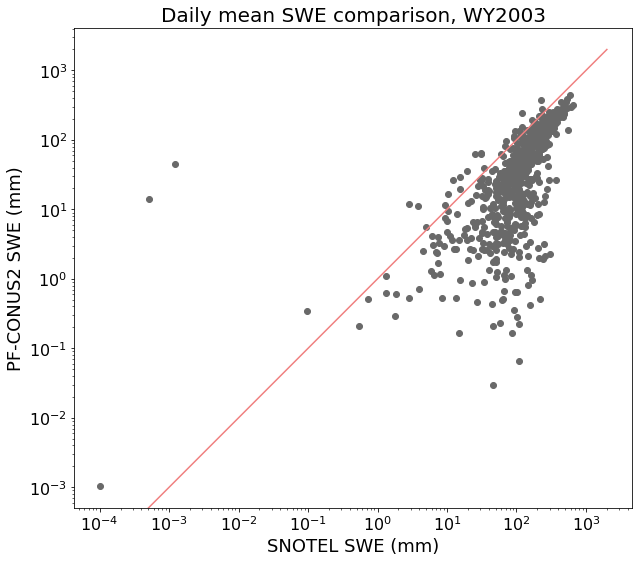

In [25]:
# Scatter plot of daily mean flow for  WY2003, PF vs. USGS
fig = plt.figure(figsize=(10,10), dpi=72)
ax = fig.add_subplot()

ax.scatter(stats_df['USGS_mean_mm'], stats_df['PF_mean_mm'], color = 'dimgrey')
ax.plot(range(2000), color = 'lightcoral')
plt.ylabel('PF-CONUS2 SWE (mm)',fontsize=18)
plt.xlabel('SNOTEL SWE (mm)',fontsize=18)
plt.title('Daily mean SWE comparison, WY2003',fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
# square plot
ax.set_aspect('equal', adjustable='box')#########THIS IS BROKENNNNNNNNNNN
plt.savefig(f'{plot_dir}/WY2003_daily_SWE_comparison_scatter.png')


## Map Plots

In [26]:
from PIL import Image

# Read in CONUS2 mask and HUC2 png for map plot border and HUC2 outlines
CONUS2_mask = Image.open('/hydrodata/PFCLM/CONUS2_baseline/inputs/domain_files/CONUS2.0.Final1km.Mask.tif')
mask_array = np.array(CONUS2_mask)
HUC2_outline = Image.open('/home/dtt2/CONUS2/PFCONUS2-analysis/scripts/Validation/mapping_scripts/CONUS2_outline_with_HUC2_noSqrBorder.png')


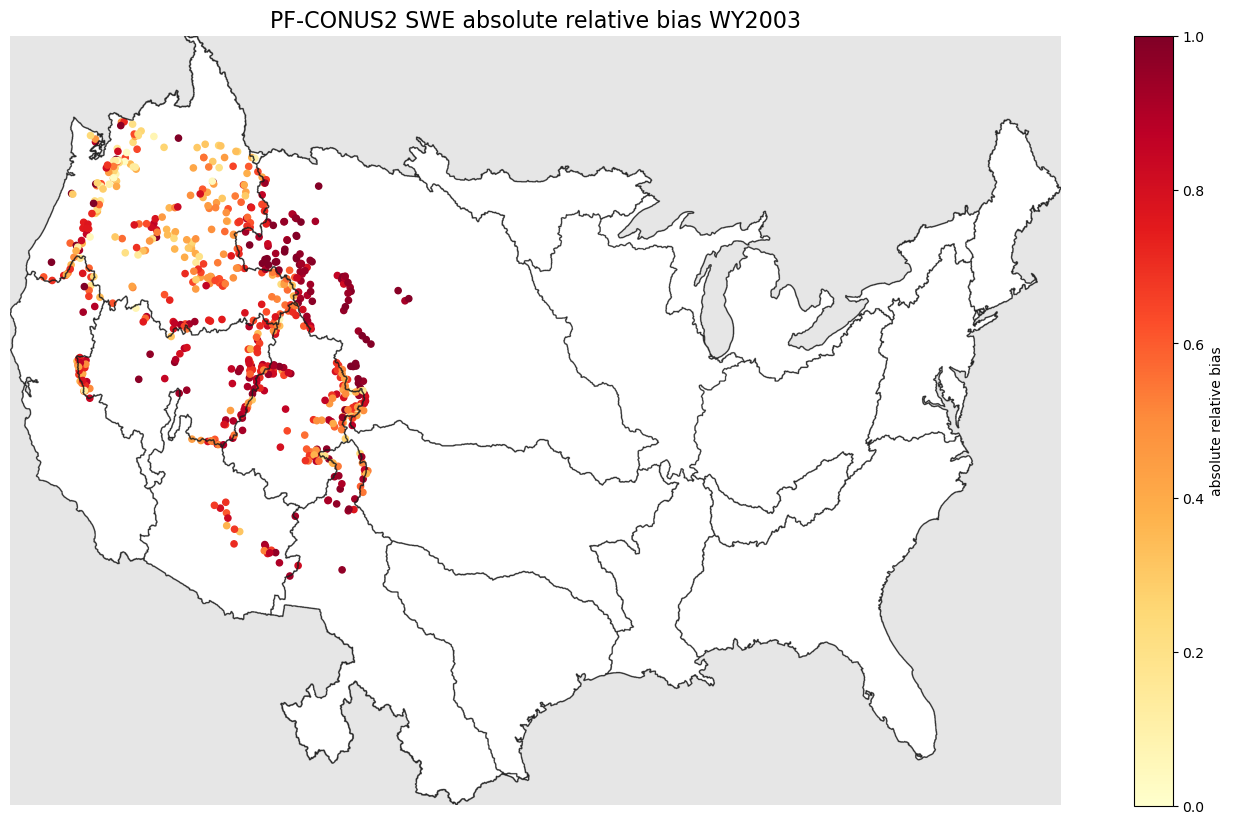

In [28]:
### Absolute Relative Bias
### Good values are closer to 0.0
fig, ax = plt.subplots(1,1,figsize=(19,10))
ax.imshow(HUC2_outline, extent=[0, 4442, 0, 3256],zorder=2)
ax.imshow(mask_array[::-1,:], origin='lower', cmap='Greys_r', alpha = 0.1) # CONUS2 outline 
points = ax.scatter(stats_df.conus2_x,stats_df.conus2_y, c=stats_df.absrelbias, cmap='YlOrRd', s=20, vmin = 0, vmax = 1, zorder=1)
plt.colorbar(points, label = 'absolute relative bias')
plt.title(f'PF-CONUS2 SWE absolute relative bias WY{water_year}', fontsize = 16)
plt.axis('off')
plt.savefig(f'{plot_dir}/PFCONUS2_SWE_AbsRelBias_Map_WY{water_year}.png',\
            dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")

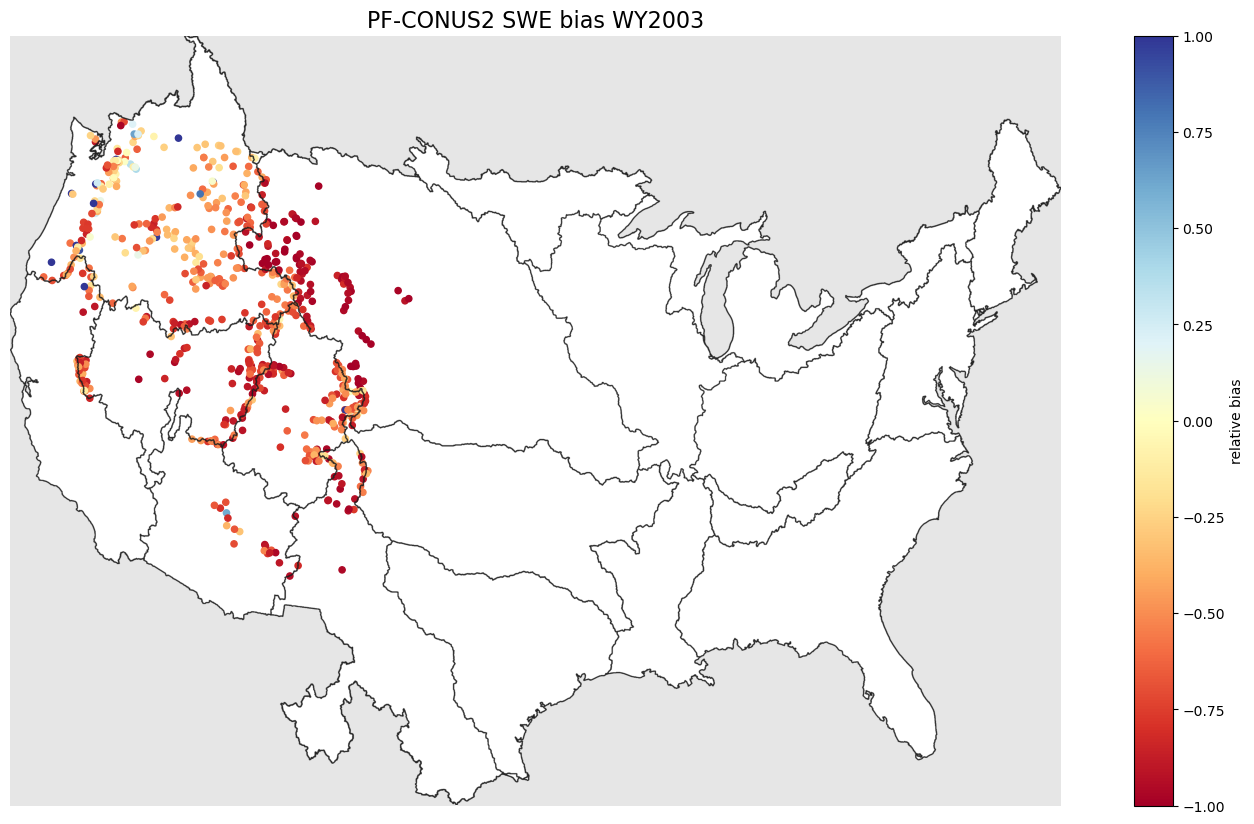

In [29]:
### Relative Bias
### Good values are closer to 0.0, positive is PF overestimation, negative is PF underestimation
fig, ax = plt.subplots(1,1,figsize=(19,10))
ax.imshow(HUC2_outline, extent=[0, 4442, 0, 3256],zorder=2)
ax.imshow(mask_array[::-1,:], origin='lower', cmap='Greys_r', alpha = 0.1) # CONUS2 outline 
points = ax.scatter(stats_df.conus2_x,stats_df.conus2_y, c=stats_df.bias, cmap='RdYlBu', s=20, vmin = -1, vmax = 1, zorder=1)
plt.colorbar(points, label = 'relative bias')
plt.axis('off')
plt.title(f'PF-CONUS2 SWE bias WY{water_year}', fontsize = 16)
plt.savefig(f'{plot_dir}/PFCONUS2_SWE_RelBias_Map_WY{water_year}.png',\
            dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")

In [14]:
print(stats_df.pf_minus_obs.max())
stats_df.pf_minus_obs.min()

501896.885179908


-2376575.259631489

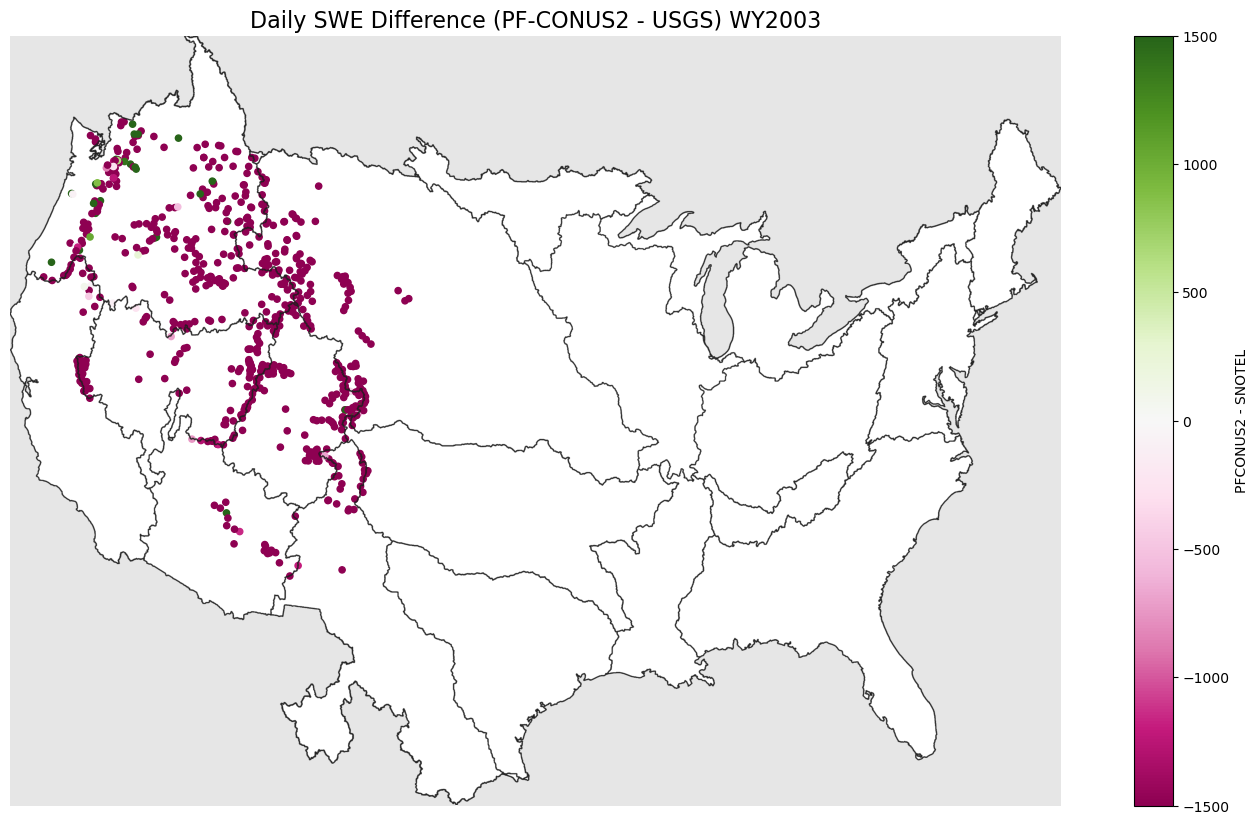

In [30]:
### PF - USGS
### Good values are closer to 0.0, positive is PF overestimation, negative is PF underestimation
fig, ax = plt.subplots(1,1,figsize=(19,10))
ax.imshow(HUC2_outline, extent=[0, 4442, 0, 3256],zorder=2)
ax.imshow(mask_array[::-1,:], origin='lower', cmap='Greys_r', alpha = 0.1) # CONUS2 outline 
points = ax.scatter(stats_df.conus2_x,stats_df.conus2_y, c=stats_df.pf_minus_obs, cmap='PiYG', vmin = -1500, vmax = 1500, s=20, zorder=1)
plt.colorbar(points, label = 'PFCONUS2 - SNOTEL') #
plt.title(f'Daily SWE Difference (PF-CONUS2 - USGS) WY{water_year}', fontsize = 16)
plt.axis('off')
plt.savefig(f'{plot_dir}/PFCONUS2_SWE-Diff_PF-SNOTEL_WY{water_year}.png',\
            dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")

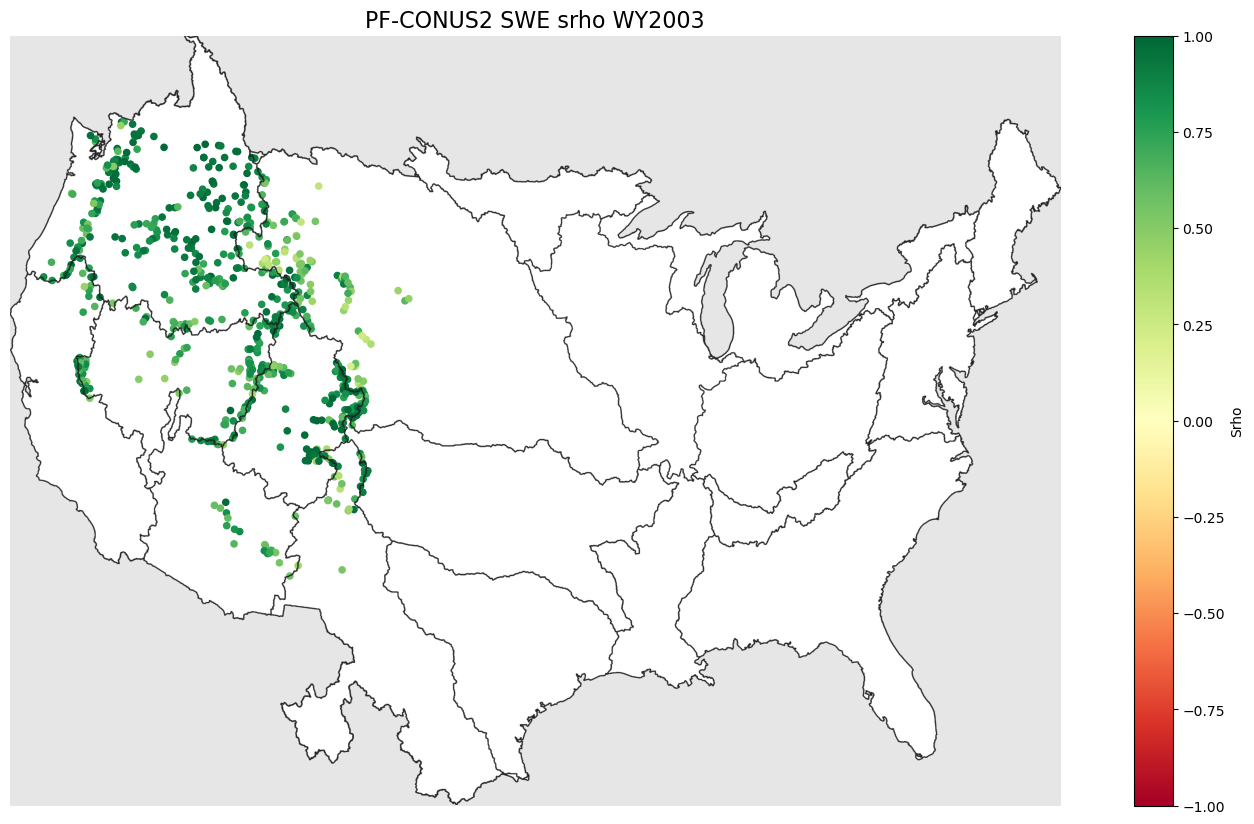

In [31]:
### Spearmans's Rho
### Good values are closer to 0.0
fig, ax = plt.subplots(1,1,figsize=(19,10))
ax.imshow(HUC2_outline, extent=[0, 4442, 0, 3256],zorder=2)
ax.imshow(mask_array[::-1,:], origin='lower', cmap='Greys_r', alpha = 0.1) # CONUS2 outline 
points = ax.scatter(stats_df.conus2_x,stats_df.conus2_y, c=stats_df.srho, s=20, vmin = -1, vmax = 1, cmap = 'RdYlGn', zorder=1)
plt.colorbar(points, label = 'Srho')
plt.axis('off')
plt.title(f'PF-CONUS2 SWE srho WY{water_year}', fontsize = 16)
plt.savefig(f'{plot_dir}/PFCONUS2_SWE_Srho_Map_WY{water_year}.png',\
            dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")

In [ ]:

# plt.figure(figsize=(5,5))
# n, bins_limits, patches = plt.hist(obsv, bins=np.logspace(np.log10(1e-6),np.log10(1e7), 80), color='r', alpha=0.5, label='USGS')
# plt.hist(simv, bins = bins_limits, color='b', alpha=0.5, label='CONUS2')
# plt.xlabel('streamflow ($\mathregular{m^3}$/h)')
# plt.ylabel('Frequency')
# plt.xscale('log')
# plt.legend()
# plt.xlim(1e-2,1e8)
